# Modelling fluid flows

- Importing modules

In [ ]:
# !pip install -r ../requirements.txt


In [1]:
import pysindy as ps
import pydmd
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import cupy as cp
import jax 
import jax.numpy as jnp
import jax.scipy as jsp
import logging

logging.basicConfig(filename='errors.log', level=logging.ERROR)
# from velocity_models import VelocityModeler, run_comprehensive_analysis
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pydmd import DMD
from sklearn.metrics import mean_squared_error, r2_score
import pydmd
from pydmd import DMD
from pydmd.hankeldmd import hankel_preprocessing
# functions = [DMD, HODMD, HODMDc, DMDc, BOPDMD, CDMD, DMDBase, EDMD, FbDMD, HankelDMD, RDMD]
import matplotlib.pyplot as plt
import numpy as np
import pydmd 
import torch
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from sklearn.metrics import mean_squared_error, r2_score
import pysindy as ps

/usr/local/python/3.12.1/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


## Data Visualization

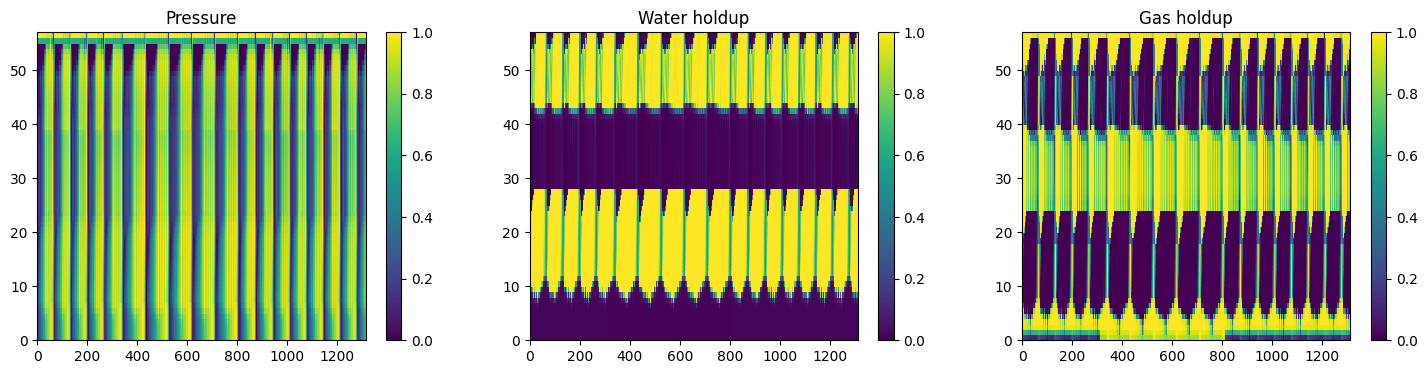

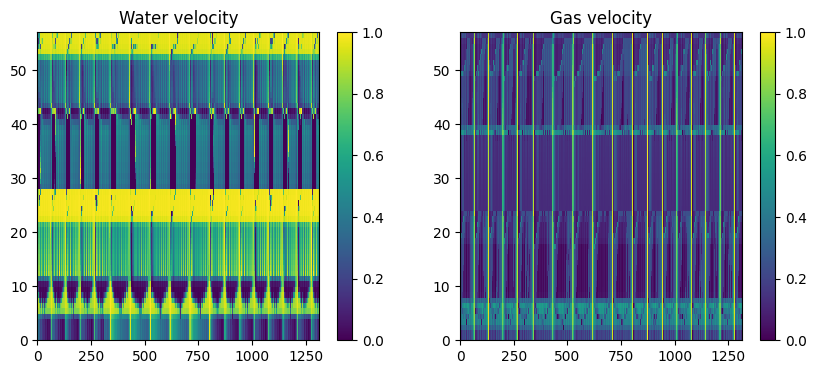

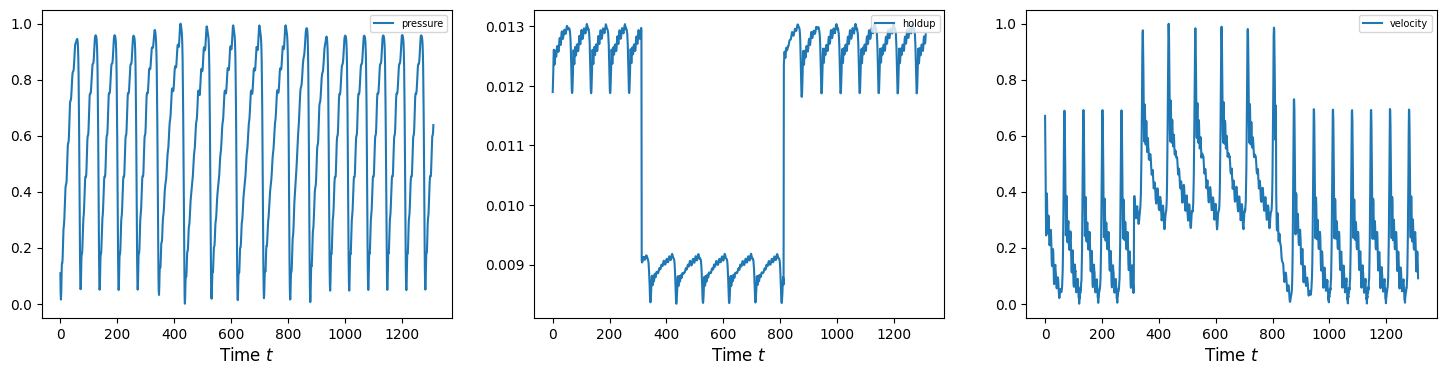

In [2]:


path = r'../data/'
df0 = pd.read_csv(path + 'pressure.csv', index_col=False, header=None)

df1 = pd.read_csv(path + 'water_holdup.csv', index_col=False, header=None)

df2 = pd.read_csv(path + 'water_velocity.csv', index_col=False, header=None)

df3 = pd.read_csv(path + 'gas_holdup.csv', index_col=False, header=None)

df4 = pd.read_csv(path + 'gas_velocity.csv', index_col=False, header=None)

df5 = pd.read_csv(path + 'x.csv', index_col=False, header=None)

df6 = pd.read_csv(path + 't.csv', index_col=False, header=None)

t_start = 0 

x_end = 57

x = df5.iloc[:x_end,0].to_numpy()

t = df6.iloc[t_start:,0].T.to_numpy()

pressure = df0.iloc[t_start:,:x_end].to_numpy().T

water_holdup = df1.iloc[t_start:,:x_end].to_numpy().T

water_velocity = df2.iloc[t_start:,:x_end].to_numpy().T

gas_holdup = df3.iloc[t_start:,:x_end].to_numpy().T

gas_velocity = df4.iloc[t_start:,:x_end].to_numpy().T

L = x[-1] # length of spatial domain
N = len(x) # number of spatial points in [0,L]

#T = t[-1] # total time
T = len(t) # number of temporal points in [0,T]
Nt = len(t)-1
#Input data

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.title("Pressure")
plt.pcolor(pressure)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Water holdup")
plt.pcolor(water_holdup)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Gas holdup")
plt.pcolor(gas_holdup)
plt.colorbar()
plt.show()
#Output data

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
plt.title("Water velocity")
plt.pcolor(water_velocity)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Gas velocity")
plt.pcolor(gas_velocity)
plt.colorbar()
plt.show()

x_location = 0

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(pressure.T[:,x_location],'-',label='pressure')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.subplot(1, 3, 2)
plt.plot(water_holdup.T[:,x_location],'-',label='holdup')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.subplot(1, 3, 3)
plt.plot(water_velocity.T[:,x_location],'-',label='velocity')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.show()

## Building the data matrix

In [7]:
# stack the matrices of pressure, water holdup, and gas holdup
P_wh_ph = np.vstack((pressure, water_holdup, gas_holdup))

# stack the matrices of water velocity, gas velocity
v_w_g = np.vstack((water_velocity, gas_velocity))

# stack the matrices of pressure, water holdup, gas holdup, water velocity, gas velocity,
P_wh_ph_v_w_g = np.vstack((P_wh_ph, v_w_g))

# print the shape of the each matrix :
print(f"Shape of P_wh_ph: {P_wh_ph.shape}\nShape of v_w_g: {v_w_g.shape}\nShape of P_wh_ph_v_w_g: {P_wh_ph_v_w_g.shape}")

xx = np.concatenate((x,x))

Shape of P_wh_ph: (171, 1313)
Shape of v_w_g: (114, 1313)
Shape of P_wh_ph_v_w_g: (285, 1313)


## Data Modelling assumption
### 1. Model 1
In this model, we assume that we can modelize the ```water_velocity```, ```gas_velocity``` ($y_t \in \mathbb{R}^{2n}$) based on the  ```pressure```, ```water_holdup```, ```gas_holdup```($x_t\in \mathbb{R}^{3n}$).  

```P_wh_ph```=$\left[\begin{matrix}x_0&\cdots&x_T\end{matrix}\right]$.  
```v_w_g``` = $\left[\begin{matrix}y_0&\cdots&y_T\end{matrix}\right]$.  
```P_wh_ph_v_w_g``` = $\left[\begin{matrix}x_0&\cdots&x_T\\y_0&\cdots&y_T\end{matrix}\right]$.


The relation is assumed as follow: $y_t = F(x_t)$ or more generally, for some $d$: $$y_t = F(x_t, \cdots, x_{t-d+1})$$
#### 1.1. Linear regression
- Assumption: Given $y_0, \cdots, y_{d-1}$, we want to find the best fit matrix $A$ such that:
$$y_d = A' \left[\begin{matrix}x_0\\\vdots \\x_{d-1}\end{matrix}\right] + b_d = \left[ \begin{matrix}A'\ & b_d \end{matrix} \right]\left[\begin{matrix}x_0\\\vdots \\x_{d-1}\\1\end{matrix}\right]\\ \vdots\\ \\y_T = A'\left[\begin{matrix}x_{T-d+1}\\\vdots\\ x_{T}\end{matrix}\right] +b_T=\left[ \begin{matrix}A'\ & b_T \end{matrix} \right]\left[\begin{matrix}x_{T-d+1}\\\vdots\\ x_{T}\\1\end{matrix}\right]\\\Leftrightarrow \\ \left[\begin{matrix}y_d&\cdots&y_T\end{matrix}\right] = A \left[\begin{matrix}x_0&\cdots &x_{T-d+1}\\\vdots&&\vdots\\x_{d-1}&\cdots & x_{T-1} \\ 1 & \cdots & 1\end{matrix}\right]$$
$$A = \left[\begin{matrix}y_d&\cdots&y_T\end{matrix}\right] \left[\begin{matrix}x_0&\cdots &x_{T-d+1}\\\vdots&&\vdots\\x_{d-1}&\cdots & x_{T-1} \\ 1 & \cdots & 1\end{matrix}\right]^{-1}$$


- Class python model

Full Error: 0.1340


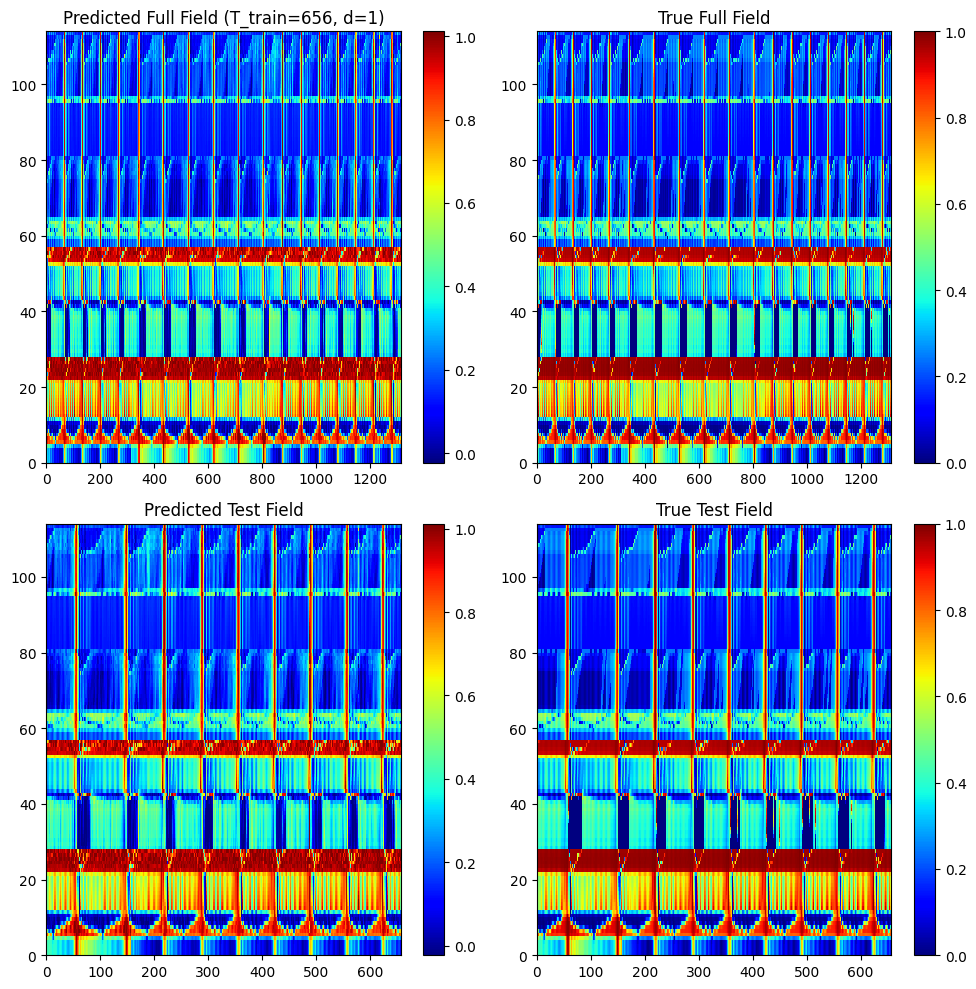

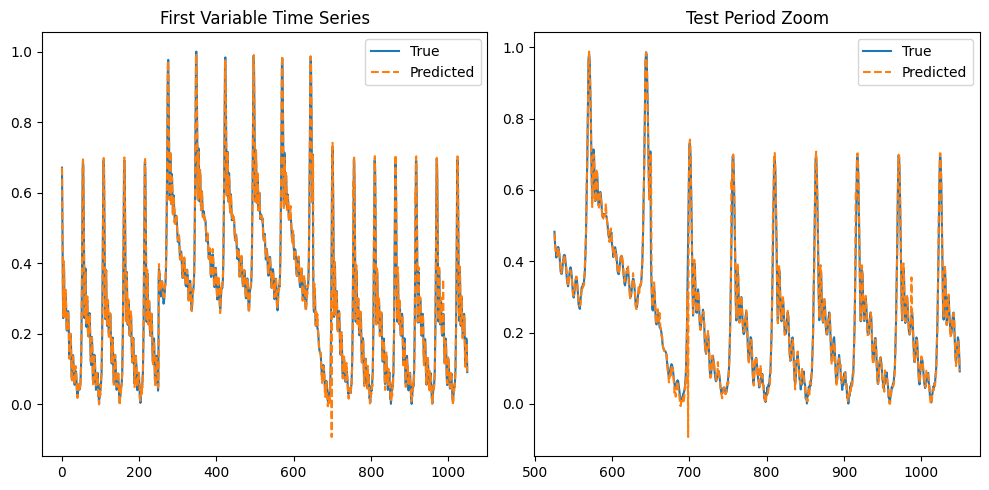

Full Error: 0.2647


[2644894205.py:147 -             <module>() ] Error: x and y must have same first dimension, but have shapes (894,) and (856,)
Traceback (most recent call last):
  File "/tmp/ipykernel_28467/2644894205.py", line 145, in <module>
    model_d_20.visualize(t)
  File "/tmp/ipykernel_28467/2644894205.py", line 121, in visualize
    plt.plot(t[self.T_train -self.d+2:], self.Y_pred_test[0,], '--', label='Predicted')
  File "/home/codespace/.local/lib/python3.12/site-packages/matplotlib/pyplot.py", line 3838, in plot
    return gca().plot(
           ^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/matplotlib/axes/_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/matplotlib/axes/_base.py", line 297, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "/home/codespace/.local

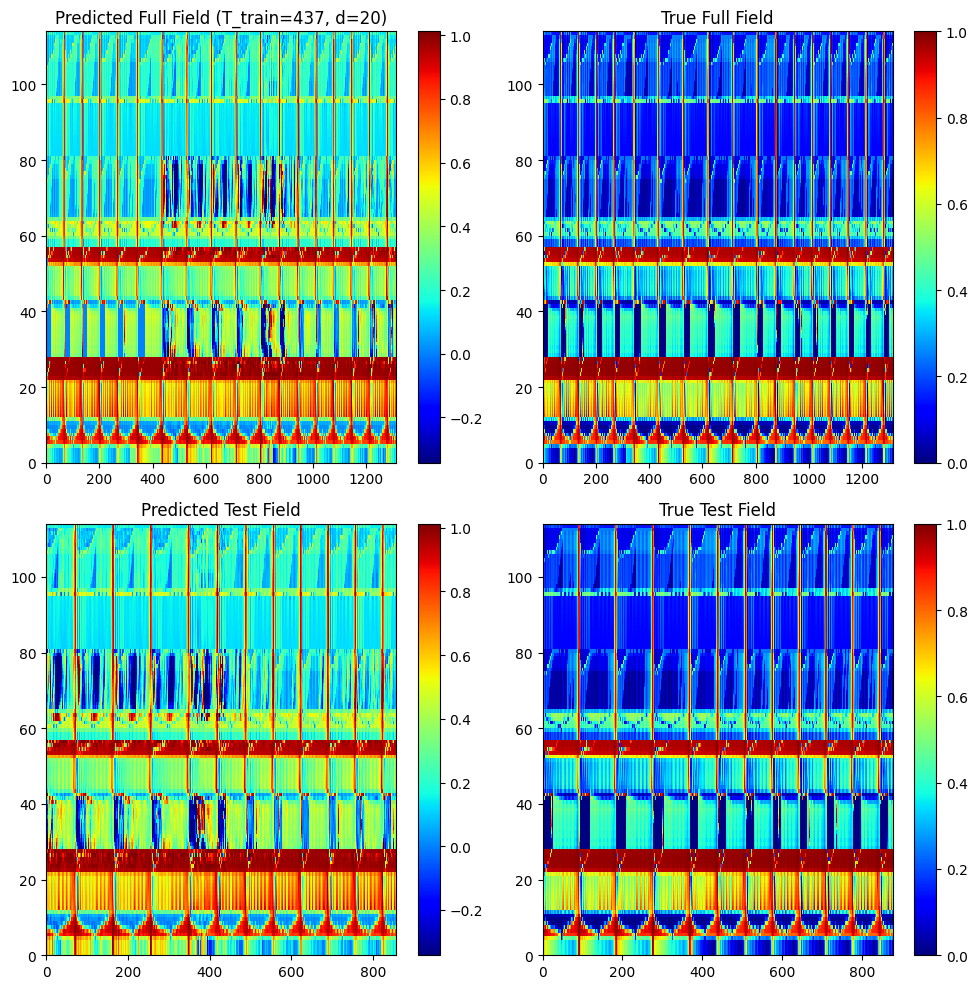

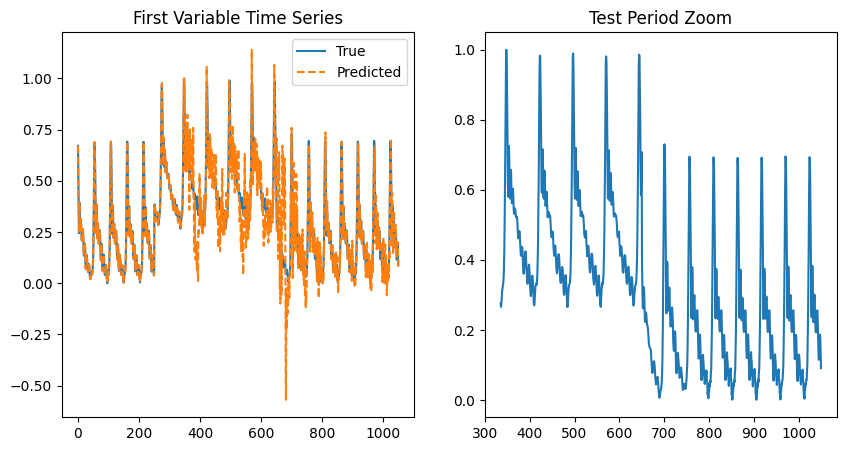

In [59]:
import numpy as np
import matplotlib.pyplot as plt

class Linear_model1:
    def __init__(self, P_wh_ph, v_w_g, Nt,T_train=3 * Nt // 4, d=1):
        """
        Initialize predictor with:
        - P_wh_ph: Pressure/phase data (predictor variables)
        - v_w_g: Velocity/holdup data (target variables)
        - Nt: Total timesteps
        - d: Time delay embedding dimension
        """
        self.P_wh_ph = P_wh_ph
        self.v_w_g = v_w_g
        self.Nt = Nt
        self.d = d
        self.T_train = T_train
        # self.T_train = 3 * Nt // 4  # 75% training split
        self.A = None  # System matrix
        
    def prepare_data(self):
        """Create training/test datasets with time-delay embedding"""
        # Target (Y) is velocity/holdup data
        self.Y_train = self.v_w_g[:, self.d : self.T_train]
        
        # Predictor (Z) stacks delayed pressure/phase data
        self.Z_train = np.vstack(
            [self.P_wh_ph[:, i : self.T_train - self.d + i] 
            for i in range(self.d)]
        )
        
        # Full/test predictors
        self.Z_full = np.vstack(
            [self.P_wh_ph[:, i : self.Nt - self.d + i + 1] 
            for i in range(self.d)]
        )
        self.Z_test = np.vstack(
            [self.P_wh_ph[:, self.T_train + i : self.Nt - self.d + i + 1] 
            for i in range(self.d)]
        )
    
    def train(self):
        """Train the model using pseudo-inverse"""
        Z_inv = np.linalg.pinv(self.Z_train)
        self.A = self.Y_train @ Z_inv
    
    def predict(self):
        """Generate predictions"""
        # Initial condition (first d timesteps)
        self.Y_pred_full1 = self.v_w_g[:, :self.d]
        
        # Predicted values
        self.Y_pred_full2 = self.A @ self.Z_full
        self.Y_pred_full = np.hstack([self.Y_pred_full1, self.Y_pred_full2])
        
        # Test predictions
        self.Y_pred_test = self.A @ self.Z_test
    
    def evaluate(self):
        """Calculate prediction errors"""
        train_error = np.linalg.norm(
            self.Y_pred_full - self.v_w_g) / np.linalg.norm(self.v_w_g)
        # test_error = np.linalg.norm(
        #     self.Y_pred_test - self.v_w_g[:, self.T_train - self.d +2 : ]
        # ) / np.linalg.norm(self.v_w_g[:, self.T_train - self.d +2 : ])
        
        print(f"Full Error: {train_error:.4f}")
        # print(f"Test Error: {test_error:.4f}")
        return train_error#, test_error
    
    def visualize(self, t):
        """Generate diagnostic plots"""
        plt.figure(figsize=(10, 10))
        
        # Full field comparisons
        plt.subplot(2, 2, 1)
        plt.title(f"Predicted Full Field (T_train={self.T_train}, d={self.d})")
        plt.pcolormesh(
            self.Y_pred_full, 
            cmap='jet', 
            vmin=np.percentile(self.Y_pred_full, 1),
            vmax=np.percentile(self.Y_pred_full, 99)
        )
        plt.colorbar()
        
        plt.subplot(2, 2, 2)
        plt.title("True Full Field")
        plt.pcolormesh(self.v_w_g, cmap='jet')
        plt.colorbar()
        
        # Test set comparisons
        plt.subplot(2, 2, 3)
        plt.title(f"Predicted Test Field")
        plt.pcolormesh(
            self.Y_pred_test,
            cmap='jet',
            vmin=np.percentile(self.Y_pred_full, 1),
            vmax=np.percentile(self.Y_pred_full, 99)
        )
        plt.colorbar()
        
        plt.subplot(2, 2, 4)
        plt.title("True Test Field")
        plt.pcolormesh(self.v_w_g[:, self.T_train:], cmap='jet')
        plt.colorbar()
        
        plt.tight_layout()
        
        # Time series comparisons
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title(f"First Variable Time Series")
        plt.plot(t, self.v_w_g[0, :], label='True')
        plt.plot(t, self.Y_pred_full[0,], '--', label='Predicted')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.title(f"Test Period Zoom")
        plt.plot(t[self.T_train -self.d+2:], self.v_w_g[0, self.T_train -self.d+2:], label='True')
        plt.plot(t[self.T_train -self.d+2:], self.Y_pred_test[0,], '--', label='Predicted')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Usage example
if __name__ == "__main__":
    try:
    # Initialize and run model
        model_d_1 = Linear_model1(P_wh_ph, v_w_g, Nt,T_train=Nt//2, d=1)
        model_d_1.prepare_data()
        model_d_1.train()
        model_d_1.predict()
        model_d_1.evaluate()
        model_d_1.visualize(t)
    except Exception as e:
        logging.error(f"Error: {e}", exc_info=True)
    try:
        model_d_20 = Linear_model1(P_wh_ph, v_w_g, Nt,T_train=Nt//3, d=20)
        model_d_20.prepare_data()
        model_d_20.train()
        model_d_20.predict()
        model_d_20.evaluate()
        model_d_20.visualize(t)
    except Exception as e:
        logging.error(f"Error: {e}", exc_info=True)


T_train: 656

Y_train shape: (114, 655)
Z_train shape: (171, 655)

A shape: (114, 171)

Z_full shape: (171, 1312)
Z_test shape: (171, 656)

Y_pred_full shape: (114, 1313)

Y_pred_full shape: (114, 1313)
Y_pred_test shape: (114, 656)

Accuracy between Y_pred_full and Y_full: 0.13397886856441482

Accuracy between Y_pred_test and Y_test: 15.122413667953014



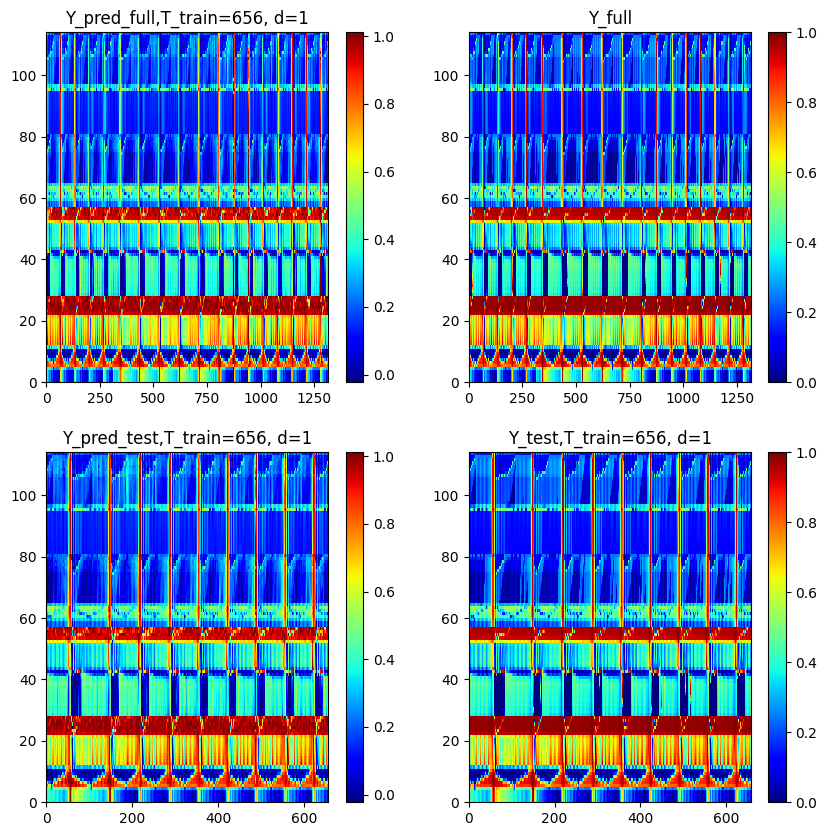

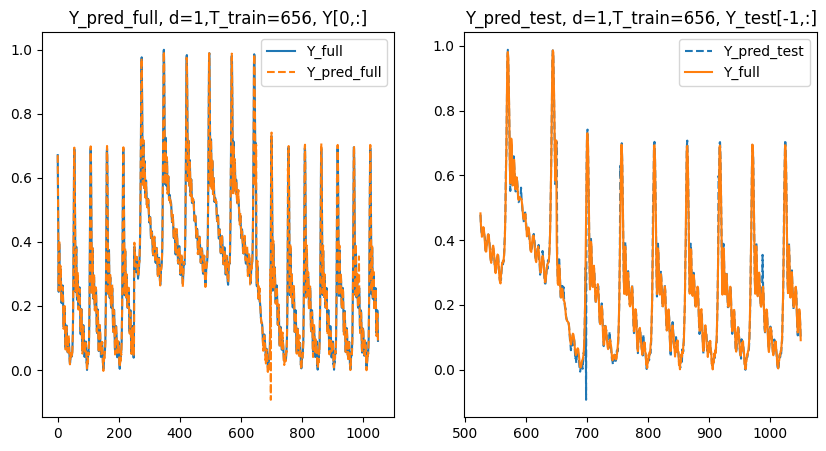

In [8]:
T_train = 2*Nt//4
print(f"T_train: {T_train}\n")
# Predictor variables Z and target variable Y
Z = [] # each element will be stack the matrices of pressure, water holdup, gas holdup, water velocity, gas velocity
d = 1
Y = [] # each element will be stack the matrices of water holdup, water velocity
Z = P_wh_ph
Y = v_w_g

Y_train = Y[:,d:T_train]
Z_train = np.vstack([Z[:,i:T_train-d+i] for i in range(d)])

print(f"Y_train shape: {Y_train.shape}\nZ_train shape: {Z_train.shape}\n")
Z_inv = np.linalg.pinv(Z_train)
A = Y_train @ Z_inv
print(f"A shape: {A.shape}\n")
Z_full = np.vstack([Z[:,i:Nt-d+i+1] for i in range(d)])
Z_test = np.vstack([Z[:,T_train+i:Nt-d+i+1] for i in range(d)])
print(f"Z_full shape: {Z_full.shape}\nZ_test shape: {Z_test.shape}\n")
Y_pred_full1 = Y [:,:d] 
Y_pred_full2 = A @ Z_full
Y_pred_full = np.hstack([Y_pred_full1,Y_pred_full2])
print(f"Y_pred_full shape: {Y_pred_full.shape}\n")
# Y_pred_full = np.vstack([Y_pred_full1,Y_pred_full2])
Y_pred_test = A @ Z_test
print(f"Y_pred_full shape: {Y_pred_full.shape}\nY_pred_test shape: {Y_pred_test.shape}\n")
print(f"Accuracy between Y_pred_full and Y_full: {np.linalg.norm(Y_pred_full - Y)/np.linalg.norm(Y)}\n")
print(f"Accuracy between Y_pred_test and Y_test: {np.linalg.norm(Y_pred_test - Y[:,T_train-d:T_train])/np.linalg.norm(Y[:,T_train-d:T_train])}\n")

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title(f"Y_pred_full,T_train={T_train}, d={d}")
plt.pcolormesh(Y_pred_full,cmap='jet',label='Y_pred_full', vmin=np.percentile(Y_pred_full,1), vmax=np.percentile(Y_pred_full,99)) # vmin and vmax are used to normalize the data, they are the percentiles of the data
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title("Y_full")
plt.pcolormesh(Y,cmap='jet',label='Y_full')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.title(f"Y_pred_test,T_train={T_train}, d={d}")
plt.pcolormesh(Y_pred_test,cmap='jet',label='Y_pred_test', vmin=np.percentile(Y_pred_full,1), vmax=np.percentile(Y_pred_full,99)) # vmin and vmax are used to normalize the data, they are the percentiles of the data
plt.colorbar()
plt.subplot(2, 2, 4)
plt.title(f"Y_test,T_train={T_train}, d={d}")
plt.pcolormesh(Y[:,T_train:],cmap='jet',label='Y_test')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title(f"Y_pred_full, d={d},T_train={T_train}, Y[0,:]")
plt.plot(t,Y[0,:],label='Y_full')
plt.plot(t,Y_pred_full[0,:],"--",label='Y_pred_full')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.title(f"Y_pred_test, d={d},T_train={T_train}, Y_test[-1,:]")
plt.plot(t[T_train+1:],Y_pred_test[0,:],"--",label='Y_pred_test')
plt.plot(t[T_train+1:],Y[0,T_train+1:],label='Y_full')
plt.legend(loc='upper right')

plt.show()


- Analysis on $d$ and T_train

In [87]:
print("Relative error between Y_pred_full and Y:")
for T_train in [3*Nt//4, 2*Nt//3, Nt//2, Nt//3, Nt//4]:
    print()
    for d in [3*T_train//4, 2*T_train//3, T_train//2, T_train//3, T_train//4,1]:
        
        T_train = int(T_train)
        d = int(d)
        # Predictor variables Z and target variable Y
        Y_train = Y[:,d:T_train]
        Z_train = np.vstack([Z[:,i:T_train-d+i] for i in range(d)])

        # print(f"Y_train shape: {Y_train.shape}\nZ_train shape: {Z_train.shape}\n")
        Z_inv = np.linalg.pinv(Z_train)
        A = Y_train @ Z_inv
        # print(f"A shape: {A.shape}\n")
        Z_full = np.vstack([Z[:,i:Nt-d+i+1] for i in range(d)])
        Z_test = np.vstack([Z[:,T_train+i:Nt-d+i+1] for i in range(d)])
        # print(f"Z_full shape: {Z_full.shape}\nZ_test shape: {Z_test.shape}\n")
        Y_pred_full1 = Y [:,:d] 
        Y_pred_full2 = A @ Z_full
        Y_pred_full = np.hstack([Y_pred_full1,Y_pred_full2])
        # print(f"Y_pred_full shape: {Y_pred_full.shape}\n")
        # Y_pred_full = np.vstack([Y_pred_full1,Y_pred_full2])
        Y_pred_test = A @ Z_test
        # print(f"Y_pred_full shape: {Y_pred_full.shape}\nY_pred_test shape: {Y_pred_test.shape}\n")
        print(f"d: {d},T_train: {T_train}, error: {np.linalg.norm(Y_pred_full - Y)/np.linalg.norm(Y)}\n")
        # print(f"Accuracy between Y_pred_test and Y_test: {np.linalg.norm(Y_pred_test - Y[:,T_train-d:T_train])/np.linalg.norm(Y[:,T_train-d:T_train])}\n")


Relative error between Y_pred_full and Y:

d: 738,T_train: 984, error: 0.1845507617861709

d: 656,T_train: 984, error: 0.1972235549955966

d: 492,T_train: 984, error: 0.15948853362910861

d: 328,T_train: 984, error: 0.1397506629964965

d: 246,T_train: 984, error: 0.0654434162927359

d: 1,T_train: 984, error: 0.08508678694418481


d: 655,T_train: 874, error: 0.3007410442759141

d: 582,T_train: 874, error: 0.29532242825176497

d: 437,T_train: 874, error: 0.29833799695581986

d: 291,T_train: 874, error: 0.17425042465315962

d: 218,T_train: 874, error: 0.0931799564569837

d: 1,T_train: 874, error: 0.09115779095089283


d: 492,T_train: 656, error: 0.2957090022587234

d: 437,T_train: 656, error: 0.29373380471395627

d: 328,T_train: 656, error: 0.25475395420730085

d: 218,T_train: 656, error: 0.09901214507909425

d: 164,T_train: 656, error: 0.0927070903069992

d: 1,T_train: 656, error: 0.13397886854438762


d: 327,T_train: 437, error: 0.33727906600006125

d: 291,T_train: 437, error: 0.3417954

In [91]:


columns = ['d','T_train','rel. error']
df = pd.DataFrame(columns=columns)
print("Relative error between Y_pred_full and Y:")
results = []
j = 0
for T_train in [i for i in range(10,Nt,10)]:
    for d in [i for i in range(1,T_train,10)]:
        j+=1
        T_train = int(T_train)
        d = int(d)
        # Predictor variables Z and target variable Y
        Y_train = Y[:,d:T_train]
        Z_train = np.vstack([Z[:,i:T_train-d+i] for i in range(d)])
        Z_inv = np.linalg.pinv(Z_train)
        A = Y_train @ Z_inv
        # print(f"A shape: {A.shape}\n")
        Z_full = np.vstack([Z[:,i:Nt-d+i+1] for i in range(d)])
        Z_test = np.vstack([Z[:,T_train+i:Nt-d+i+1] for i in range(d)])
        # print(f"Z_full shape: {Z_full.shape}\nZ_test shape: {Z_test.shape}\n")
        Y_pred_full1 = Y [:,:d] 
        Y_pred_full2 = A @ Z_full
        Y_pred_full = np.hstack([Y_pred_full1,Y_pred_full2])
        # print(f"Y_pred_full shape: {Y_pred_full.shape}\n")
        # Y_pred_full = np.vstack([Y_pred_full1,Y_pred_full2])
        Y_pred_test = A @ Z_test
        # print(f"Y_pred_full shape: {Y_pred_full.shape}\nY_pred_test shape: {Y_pred_test.shape}\n")
        results.append([d,T_train,np.linalg.norm(Y_pred_full - Y)/np.linalg.norm(Y)])
        # print(f"Accuracy between Y_pred_test and Y_test: {np.linalg.norm(Y_pred_test - Y[:,T_train-d:T_train])/np.linalg.norm(Y[:,T_train-d:T_train])}\n")
        if j%50 == 0:
            print(f"j: {j}, d: {d},T_train: {T_train}, rel. error: {np.linalg.norm(Y_pred_full - Y)/np.linalg.norm(Y)}")

df = pd.DataFrame(results,columns=columns)
df.to_csv('results_linear_model1.csv',index=False)

Relative error between Y_pred_full and Y:
j: 50, d: 41,T_train: 100, rel. error: 0.24147703812946741
j: 100, d: 81,T_train: 140, rel. error: 0.30870490096276104
j: 150, d: 131,T_train: 170, rel. error: 0.38049977277165137
j: 200, d: 91,T_train: 200, rel. error: 0.28597931133540627
j: 250, d: 181,T_train: 220, rel. error: 0.34335767434183523
j: 300, d: 231,T_train: 240, rel. error: 0.4113207473579279
j: 350, d: 241,T_train: 260, rel. error: 0.38462465253953754
j: 400, d: 211,T_train: 280, rel. error: 0.3170935028446606
j: 450, d: 141,T_train: 300, rel. error: 0.38531471695265646
j: 500, d: 31,T_train: 320, rel. error: 0.9535149544630063
j: 550, d: 211,T_train: 330, rel. error: 0.3706153356840089
j: 600, d: 41,T_train: 350, rel. error: 1.3205750446900941
j: 650, d: 191,T_train: 360, rel. error: 0.2997593994057263
j: 700, d: 331,T_train: 370, rel. error: 0.3682340842691
j: 750, d: 81,T_train: 390, rel. error: 0.39195234266581425
j: 800, d: 191,T_train: 400, rel. error: 0.22220739140133197

### 2. Model 2: Non Linear model
- **Problem with 1. model 1**: The linear model assumes that $y_t = A \cdot x_t$ maybe be oversimplified, limited expressiveness, poor generalization and missing the non linear phenomena in fluid dynamics.  
- **Benefits of non linear  models**: Captures complex relationships, better accuracy but may be slow in computational time, can incorporate physics knowledge, robust.  
#### 2.1. Model 2.1. Polynomial regression
- **Model form**:
$$y_t = \sum_{i=1}^{d} \sum_{j=1}^{p} \beta_{ij} x_i^j + \text{interaction terms}$$
- **Advantages and incovenients**: Simple and interpretables, capture polynomial relationships but limited to it only, can overfit with higher degreem and curse of dimensionality.
- Assumption: Given $y_0, \cdots, y_{d-1}$, we want to find the best fit matrix $A$ such that:
$$y_d = A_1 \left[\begin{matrix}x_0\\\vdots \\x_{d-1}\end{matrix}\right] + A_2 \left[\begin{matrix}x_0^2\\\vdots \\x_{d-1}^2\end{matrix}\right] +\cdots = \left[ \begin{matrix}A_1 & A_2 & \cdots \end{matrix} \right]\left[\begin{matrix}x_0\\\vdots \\x_{d-1}\\x_0^2\\\vdots \\x_{d-1}^2 \\ \vdots\end{matrix}\right]\\ \vdots\\ \\
y_T = \left[ \begin{matrix}A_1 & A_2 & \cdots \end{matrix} \right]\left[\begin{matrix}x_{T-d+1}\\\vdots \\x_{d-1}\\x_{T-d+1}^2\\\vdots \\x_{T}^2 \\ \vdots\end{matrix}\right]
\\\Leftrightarrow \\ \left[\begin{matrix}y_d&\cdots&y_T\end{matrix}\right] = A \left[\begin{matrix}x_0&\cdots &x_{T-d+1}\\\vdots&&\vdots\\x_{d-1}^2&\cdots & x_{T}^2 \end{matrix}\right]$$
$$A = \left[\begin{matrix}y_d&\cdots&y_T\end{matrix}\right] \left[\begin{matrix}x_0&\cdots &x_{T-d+1}\\\vdots&&\vdots\\x_{d-1}^2&\cdots & x_{T}^2 \end{matrix}\right]^{-1}$$

T_train: 656

Y_train shape: (114, 655)
Z_train shape: (342, 655)

A shape: (114, 342)

Z_full shape: (342, 1312)
Z_test shape: (342, 656)

Y_pred_full shape: (114, 1313)

Y_pred_full shape: (114, 1313)
Y_pred_test shape: (114, 656)

Accuracy between Y_pred_full and Y_full: 0.41759372859210847

Accuracy between Y_pred_test and Y_test: 22.672556186987144



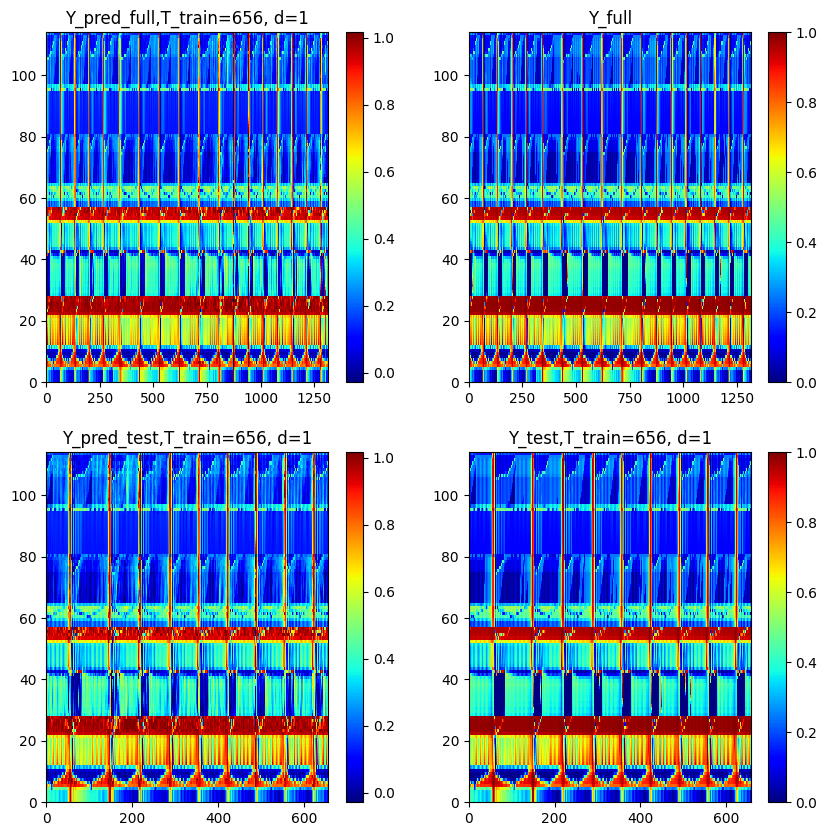

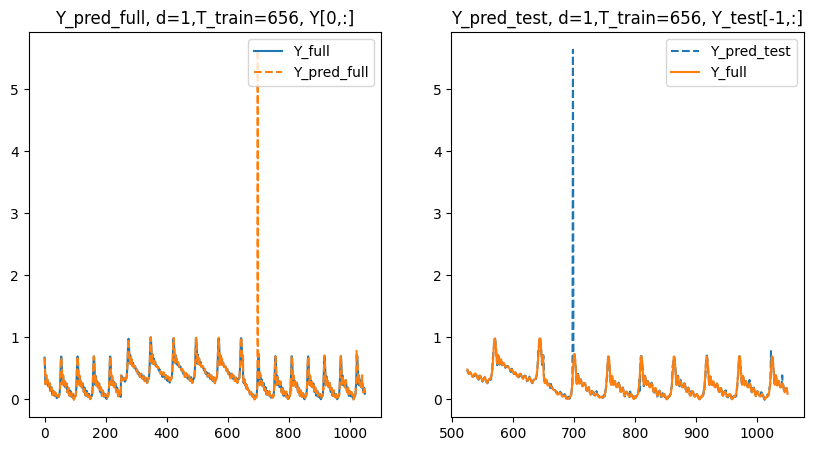

In [5]:
T_train = 2*Nt//4
print(f"T_train: {T_train}\n")
# Predictor variables Z and target variable Y
Z = [] # each element will be stack the matrices of pressure, water holdup, gas holdup, water velocity, gas velocity
d = 1
Y = [] # each element will be stack the matrices of water holdup, water velocity
Z = P_wh_ph
Y = v_w_g

Y_train = Y[:,d:T_train]
Z_train = np.vstack([Z[:,i:T_train-d+i] for i in range(d)])
Z = np.vstack([Z,Z**2])
Z_train = np.vstack([Z_train,Z_train**2])
print(f"Y_train shape: {Y_train.shape}\nZ_train shape: {Z_train.shape}\n")
Z_inv = np.linalg.pinv(Z_train)
A = Y_train @ Z_inv
print(f"A shape: {A.shape}\n")
Z_full = np.vstack([Z[:,i:Nt-d+i+1] for i in range(d)])
Z_test = np.vstack([Z[:,T_train+i:Nt-d+i+1] for i in range(d)])
print(f"Z_full shape: {Z_full.shape}\nZ_test shape: {Z_test.shape}\n")
Y_pred_full1 = Y [:,:d] 
Y_pred_full2 = A @ Z_full
Y_pred_full = np.hstack([Y_pred_full1,Y_pred_full2])
print(f"Y_pred_full shape: {Y_pred_full.shape}\n")
# Y_pred_full = np.vstack([Y_pred_full1,Y_pred_full2])
Y_pred_test = A @ Z_test
print(f"Y_pred_full shape: {Y_pred_full.shape}\nY_pred_test shape: {Y_pred_test.shape}\n")
print(f"Accuracy between Y_pred_full and Y_full: {np.linalg.norm(Y_pred_full - Y)/np.linalg.norm(Y)}\n")
print(f"Accuracy between Y_pred_test and Y_test: {np.linalg.norm(Y_pred_test - Y[:,T_train-d:T_train])/np.linalg.norm(Y[:,T_train-d:T_train])}\n")

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title(f"Y_pred_full,T_train={T_train}, d={d}")
plt.pcolormesh(Y_pred_full,cmap='jet',label='Y_pred_full', vmin=np.percentile(Y_pred_full,1), vmax=np.percentile(Y_pred_full,99)) # vmin and vmax are used to normalize the data, they are the percentiles of the data
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title("Y_full")
plt.pcolormesh(Y,cmap='jet',label='Y_full')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.title(f"Y_pred_test,T_train={T_train}, d={d}")
plt.pcolormesh(Y_pred_test,cmap='jet',label='Y_pred_test', vmin=np.percentile(Y_pred_full,1), vmax=np.percentile(Y_pred_full,99)) # vmin and vmax are used to normalize the data, they are the percentiles of the data
plt.colorbar()
plt.subplot(2, 2, 4)
plt.title(f"Y_test,T_train={T_train}, d={d}")
plt.pcolormesh(Y[:,T_train:],cmap='jet',label='Y_test')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title(f"Y_pred_full, d={d},T_train={T_train}, Y[0,:]")
plt.plot(t,Y[0,:],label='Y_full')
plt.plot(t,Y_pred_full[0,:],"--",label='Y_pred_full')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.title(f"Y_pred_test, d={d},T_train={T_train}, Y_test[-1,:]")
plt.plot(t[T_train+1:],Y_pred_test[0,:],"--",label='Y_pred_test')
plt.plot(t[T_train+1:],Y[0,T_train+1:],label='Y_full')
plt.legend(loc='upper right')

plt.show()


#### 2.2. Model 2.2. MLP Neural network
- **Model Form**:
$$y_t = f(W_n \cdot \sigma(W_{n-1} \cdot \sigma(...\sigma(W_1 \cdot x_t + b_1)...) + b_n)$$
- **Advantages and incovenients**: Universal function approximator, can capture complex pattern, good for high dimensional data. However, it is a black box model, requires significant tunning and has risk of verfitting

In [38]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor( 
    hidden_layer_sizes=(100,100,100),
    activation="relu",
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    tol=1e-4,
    verbose=True,
    random_state=42
)
print(f"T_train: {T_train}")
Z_train_shape = Z_train.shape
Y_train_shape = Z_train.shape
Z_test = Z[:,T_train:]
Y_test = Y[:,T_train]
print(f"Z_shape: {Z.shape}\nY_shape:{Y.shape}")
print(f"Z_train_shape: {Z_train.shape}\nY_train_shape:{Y_train.shape}")
print(f"Z_test_shape: {Z_test.shape}\nY_shape:{Y_test.shape}")

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_t = torch.FloatTensor(Z_train.T)
y_train_t = torch.FloatTensor(Y_train.T)
X_test_t = torch.FloatTensor(Z_test.T)
y_test_t = torch.FloatTensor(Y_test.T)
print(f"shape of X_train_t: {X_train_t.shape}")
print(f"shape of y_train_t: {y_train_t.shape}")
# Create DataLoader
train_data = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(171, 512),  # Input dim = 2
            nn.ReLU(),
            nn.Linear(512, 256),  # Input dim = 2
            nn.ReLU(),
            nn.Linear(256, 128),  # Input dim = 2
            nn.ReLU(),
            nn.Linear(128, 256),  # Input dim = 2
            nn.ReLU(),
            nn.Linear(256, 512),  # Input dim = 2
            nn.ReLU(),
            
            nn.Linear(512, 114)   # Output dim = 2
        )
    
    def forward(self, x):
        return self.layers(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch%50==0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_t = model(X_test_t)
    y_pred_full_t = model(torch.FloatTensor(Z.T))
    mse = criterion(y_pred_t, y_test_t).item()
    mse_full = criterion(y_pred_full_t, torch.FloatTensor(Y.T)).item()

print(f"Test MSE: {mse:.4f}")
print(f"Full MSE: {mse_full:.4f}")
print(f"Test Error: {torch.linalg.norm(y_pred_t-y_test_t)/torch.linalg.norm(y_test_t)}")
print(f"Full error: {torch.linalg.norm(y_pred_full_t-torch.FloatTensor(Y.T))/torch.linalg.norm(torch.FloatTensor(Y.T))}")


T_train: 656
Z_shape: (171, 1313)
Y_shape:(114, 1313)
Z_train_shape: (171, 655)
Y_train_shape:(114, 655)
Z_test_shape: (171, 657)
Y_shape:(114,)
shape of X_train_t: torch.Size([655, 171])
shape of y_train_t: torch.Size([655, 114])
Epoch 1/200, Loss: 0.0200
Epoch 51/200, Loss: 0.0019
Epoch 101/200, Loss: 0.0021
Epoch 151/200, Loss: 0.0010
Test MSE: 0.0498
Full MSE: 0.0091
Test Error: 12.888015747070312
Full error: 0.1997566521167755


#### 2.3. Random Forest Model
- **Model form**:  
Ensemble of decision trees, each trained on bootstrap sample.
- **Advantages and incovenients**: Handles non linear relationships naturally, feature importance ranking, robust to outliers, no feature scaling needed. However, it is less interpretable than linear models and can be computaionally expensive.

In [48]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
from sklearn.metrics import mean_squared_error 
model.fit(Z_train.T,Y_train.T)
Y_pred_full = model.predict(P_wh_ph.T).T
Y_pred_test = model.predict(P_wh_ph[:,T_train:].T).T



In [50]:
print(f"Test MSE: {mse:.4f}")
print(f"Full MSE: {mse_full:.4f}")
print(f"Shape Z_full: {Z_full.shape}")
print(f"Shape Y_pred_full: {Y_pred_full.shape}\nShape Y_pred_test: {Y_pred_test.shape}")
print(f"Shape Y_full: {Y.shape}\nShape Y_test: {v_w_g[:,T_train:].shape}")
print(f"Test Error: {np.linalg.norm(Y_pred_test-v_w_g[:,T_train:])/np.linalg.norm(v_w_g[:,T_train:])}")
# print(f"Full error: {np.linalg.norm(Y_pred_full-v_w_g)/np.linalg.norm((v_w_g))}")

Test MSE: 0.0498
Full MSE: 0.0091
Shape Z_full: (171, 1312)
Shape Y_pred_full: (114, 1313)
Shape Y_pred_test: (114, 657)
Shape Y_full: (114, 1313)
Shape Y_test: (114, 657)
Test Error: 0.1908530160513059


#### 2.4. Deep NEural Networks
- **Model Form**:
Multiple layers with nonlinear activations and regularizations
- **Advantages and Incovenients**: Very flexible architecture, can capture complex patterns, Good for large datasets. However, it requires significant tuning, computationally expensive, and risk of overfitting.

In [ ]:
import torch
import torch.nn as nn
class deepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(DeepNeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.BatchNorm1d(hidden_size)
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

model = deepNeuralNetwork(input_size=Z_train.shape[1], hidden_layers=[100,100,100], output_size=Y_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 1000
batch_size = 128
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for i in range(0, len(Z_train), batch_size):
        batch_Z = torch.tensor(Z_train[i:i+batch_size], dtype=torch.float32, device=device)
        batch_Y = torch.tensor(Y_train[i:i+batch_size], dtype=torch.float32, device=device)
        optimizer.zero_grad()
        outputs = model(batch_Z)


#### 2.4. Ensemble Methods
- **Model Form**:
Combination of multiple models: 
$$y=\frac{1}{M} \sum_{i=1}^M f_i(x)$$
- **Advantages and incovenients**: Combines strength of different models, more robust predictions, and reduces overfitting. However it is more complex and requires computational ressources.


In [ ]:
models = []
predictions = []
for model_name in ["polynomial", "MLP", "RandomForest", "DeepNeuralNetwork"]:
    pred = train_model(model_name, Z_train, Y_train, Z_test)
    predictions.append(pred)
    models.append(model_name)
ensemble_pred = np.mean(predictions, axis=0)
print(f"Ensemble prediction shape: {ensemble_pred.shape}\n")
print(f"Ensemble prediction: {ensemble_pred}\n")
print(f"Ensemble prediction error: {np.linalg.norm(ensemble_pred - Y)/np.linalg.norm(Y)}\n")


### 1. Physics-Informed Neural Networks (PINNs)

```python
class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super(PhysicsInformedNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(3, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 2)
        )
    
    def forward(self, x):
        return self.network(x)
    
    def physics_loss(self, x, y_pred):
        """Add physics constraints to loss function."""
        # Example: mass conservation constraint
        total_holdup = y_pred[:, 0] + y_pred[:, 1]  # water + gas
        return torch.mean((total_holdup - 1.0) ** 2)
```

### 2. Time Series Specific Models

```python
# LSTM for temporal modeling
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])
```

## 3. Uncertainty Quantification

```python
# Ensemble for uncertainty estimation
def predict_with_uncertainty(models, X_test, n_samples=100):
    predictions = []
    
    for _ in range(n_samples):
        # Bootstrap sample of models
        sample_models = np.random.choice(models, size=len(models))
        pred = np.mean([model.predict(X_test) for model in sample_models], axis=0)
        predictions.append(pred)
    
    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)
    
    return mean_pred, std_pred
```

## Code Usage Example

```python
# Quick start with nonlinear modeling
from nonlinear_models import run_nonlinear_analysis

# Run comprehensive analysis
modeler, comparison = run_nonlinear_analysis(
    X_data=P_wh_ph,
    Y_data=v_w_g,
    t_data=t
)

# Get best model predictions
best_model_name = min(comparison, key=lambda x: x['Test MSE'])['Model']
best_predictions = modeler.results[best_model_name.lower().replace(' ', '_')]['predictions']


- Preprocessing using sklearn scaler

In [ ]:

# n = Z_scaled.shape[1]//5
# Y_reshaped = Y_scaled.reshape(-1,1)
# print(f"Z_scaled shape: {Z_scaled.shape}\nY_reshaped shape: {Y_reshaped.shape}\n")


# split the data into training and testing sets

Z_train = Z_scaled[:T_train,:]
Z_test = Z_scaled[T_train:,:]
Y_train = Y_scaled[:T_train,:]
Y_test = Y_scaled[T_train:,:]

# print the shape of the training and testing sets
print(f"Z_train shape: {Z_train.shape}\nZ_test shape: {Z_test.shape}\nY_train shape: {Y_train.shape}\nY_test shape: {Y_test.shape}\n")



Z_train shape: (984, 171)
Z_test shape: (329, 171)
Y_train shape: (984, 114)
Y_test shape: (329, 114)



- Modelling using ML 

Accuracy between Y_pred and Y_test: 0.9377332200017371
Accuracy between Y_full_pred and Y_full: 0.9499171477018467


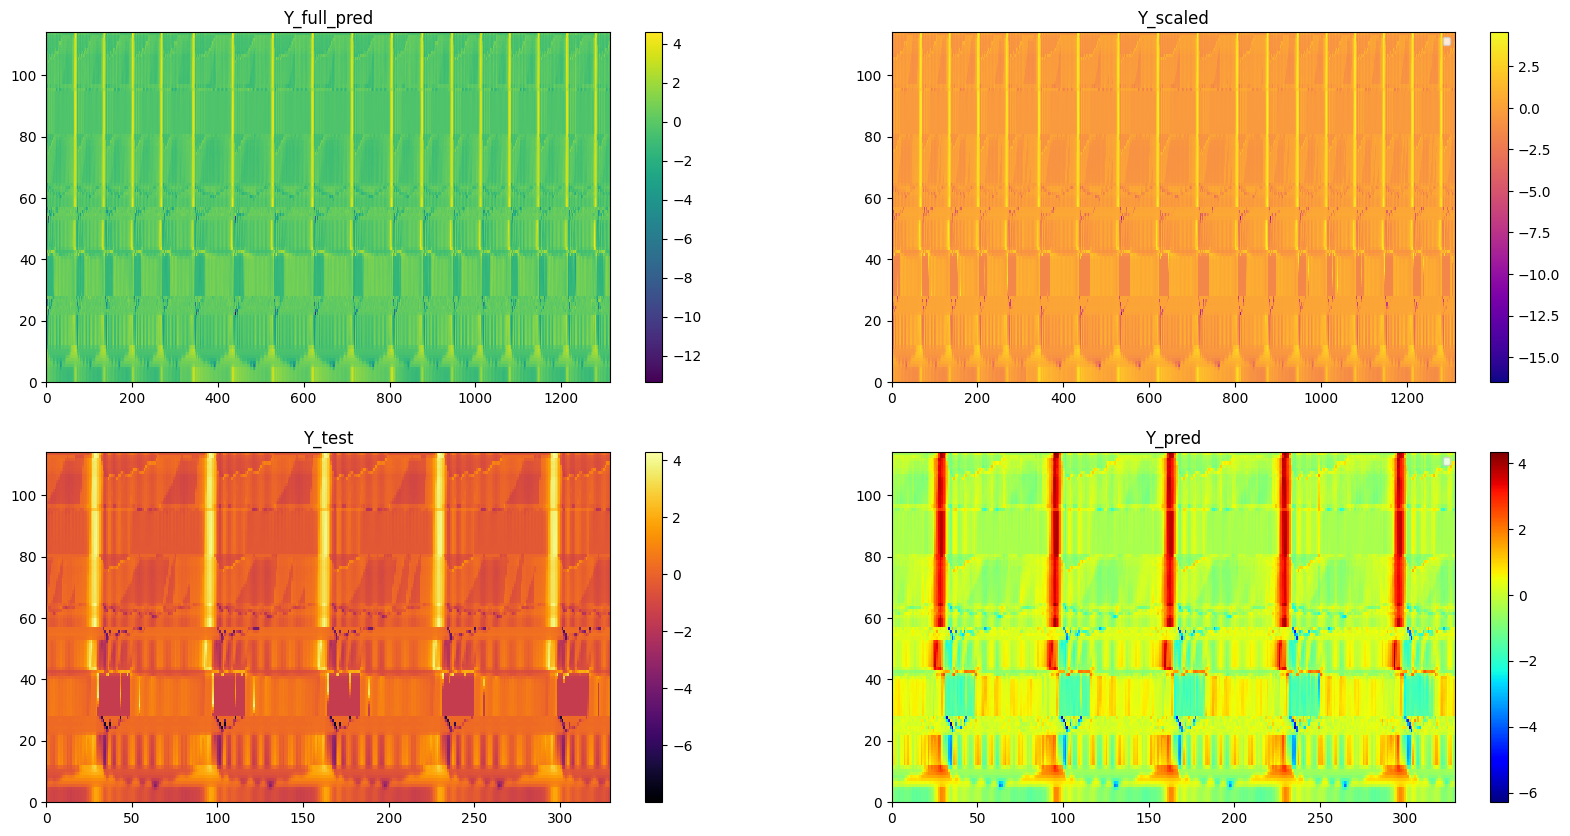

In [14]:
# Testing several models in sklearn 
collect_accuracy = {}


reg = sklearn.linear_model.LinearRegression()
reg.fit(Z_train, Y_train)
Y_pred = reg.predict(Z_test)
# Accuracy between Y_pred and Y_test
print(f"Accuracy between Y_pred and Y_test: {reg.score(Z_test, Y_test)}")
Y_full_pred = reg.predict(Z_scaled)
print(f"Accuracy between Y_full_pred and Y_full: {reg.score(Z_scaled, Y_scaled)}")
# Plotting in 2D
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title('Y_full_pred')
plt.pcolormesh(Y_full_pred.T,cmap='viridis',label='Y_full_pred')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title('Y_scaled')
plt.pcolormesh(Y_scaled.T,cmap='plasma',label='Y_scaled')
plt.colorbar()
plt.legend(loc = 1, fontsize = 7)
plt.subplot(2, 2, 3)
plt.title('Y_test')
plt.pcolormesh(Y_test.T,cmap='inferno',label='Y_test')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.title('Y_pred')
plt.pcolormesh(Y_pred.T,cmap='jet',label='Y_pred')
plt.colorbar()
plt.legend(loc = 1, fontsize = 7)
plt.show()




- Analysis based on T_train

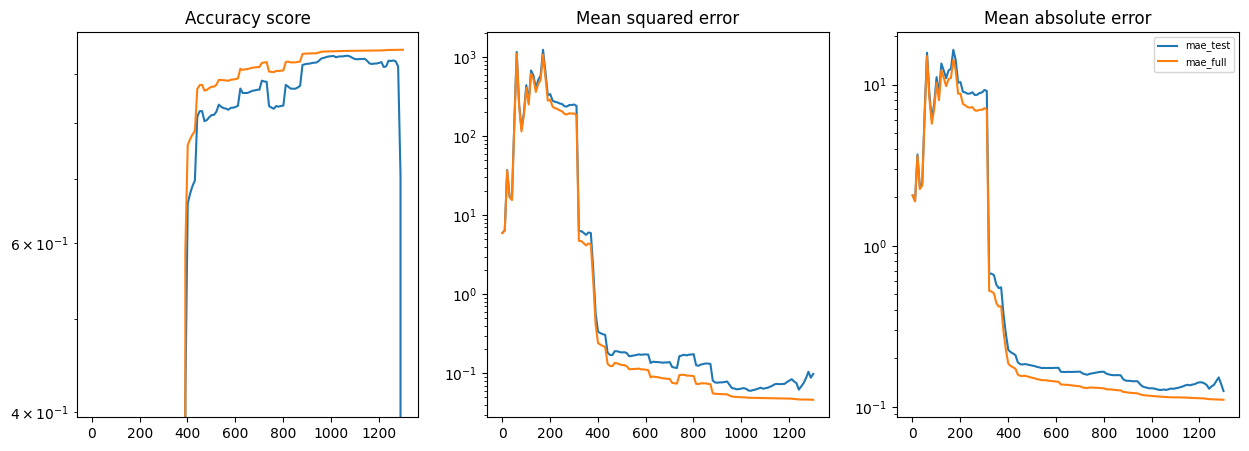

In [ ]:
accuracy_score_test = []
accuracy_score_full = []
mean_squared_error_test = []
mean_squared_error_full = []
mae_test = []
mae_full = []

t_train_values = []
for T_train in range(1,len(t)-10,10):
    t_train_values.append(T_train)
    Z_train = Z_scaled[:T_train,:]
    Z_test = Z_scaled[T_train:,:]
    Y_train = Y_scaled[:T_train,:]
    Y_test = Y_scaled[T_train:,:]
    reg = sklearn.linear_model.LinearRegression()
    reg.fit(Z_train, Y_train)
    Y_pred = reg.predict(Z_test)
    accuracy_score_test.append(reg.score(Z_test, Y_test))
    mean_squared_error_test.append(mean_squared_error(Y_test, Y_pred))
    mae_test.append(mean_absolute_error(Y_test, Y_pred))
    # print(f"Accuracy between Y_pred and Y_test: {reg.score(Z_test, Y_test)}")
    Y_full_pred = reg.predict(Z_scaled)
    accuracy_score_full.append(reg.score(Z_scaled, Y_scaled))
    mean_squared_error_full.append(mean_squared_error(Y_scaled, Y_full_pred))
    mae_full.append(mean_absolute_error(Y_scaled, Y_full_pred))
    # print(f"Accuracy between Y_full_pred and Y_full: {reg.score(Z_scaled, Y_scaled)}")
# Plotting the accuracy score
# print(f"Accuracy score test: {accuracy_score_test}\nAccuracy score full: {accuracy_score_full}")
plt.figure(figsize=(15,5))
plt.subplot(1, 3,1)
plt.title('Accuracy score')
plt.plot(t_train_values,accuracy_score_test,label='accuracy_score_test')
plt.plot(t_train_values,accuracy_score_full,label='accuracy_score_full')
plt.yscale('log')
plt.subplot(1, 3, 2)
plt.title('Mean squared error')
plt.plot(t_train_values,mean_squared_error_test,label='mean_squared_error_test')
plt.plot(t_train_values,mean_squared_error_full,label='mean_squared_error_full')
plt.yscale('log')
plt.subplot(1, 3, 3)
plt.title('Mean absolute error')
plt.plot(t_train_values,mae_test,label='mae_test')
plt.plot(t_train_values,mae_full,label='mae_full')
plt.legend(loc = 1, fontsize = 7)
plt.yscale('log')
plt.show()




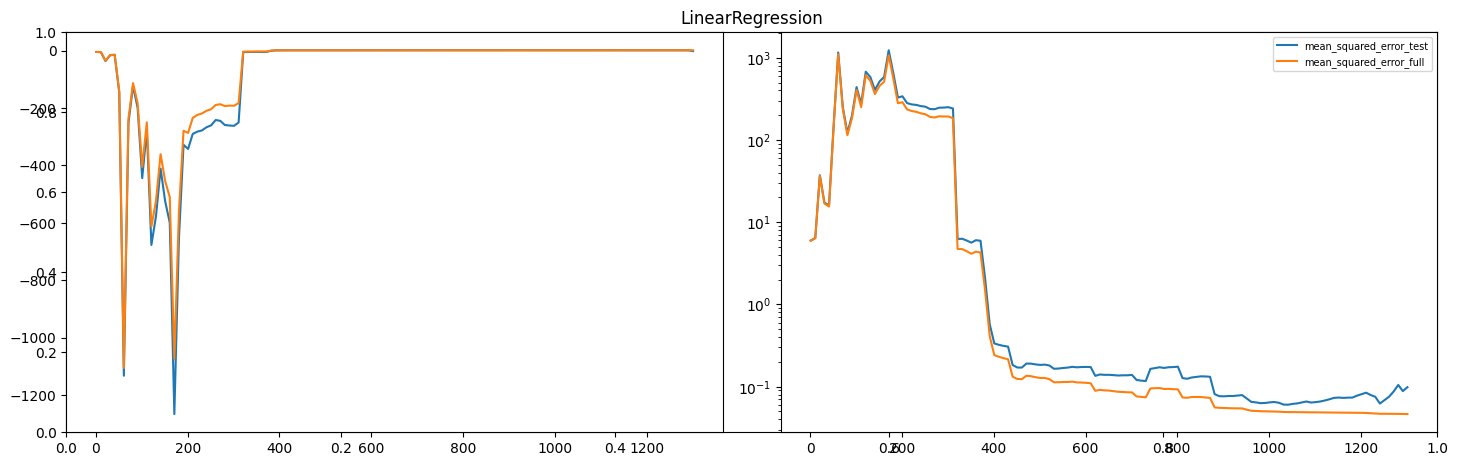

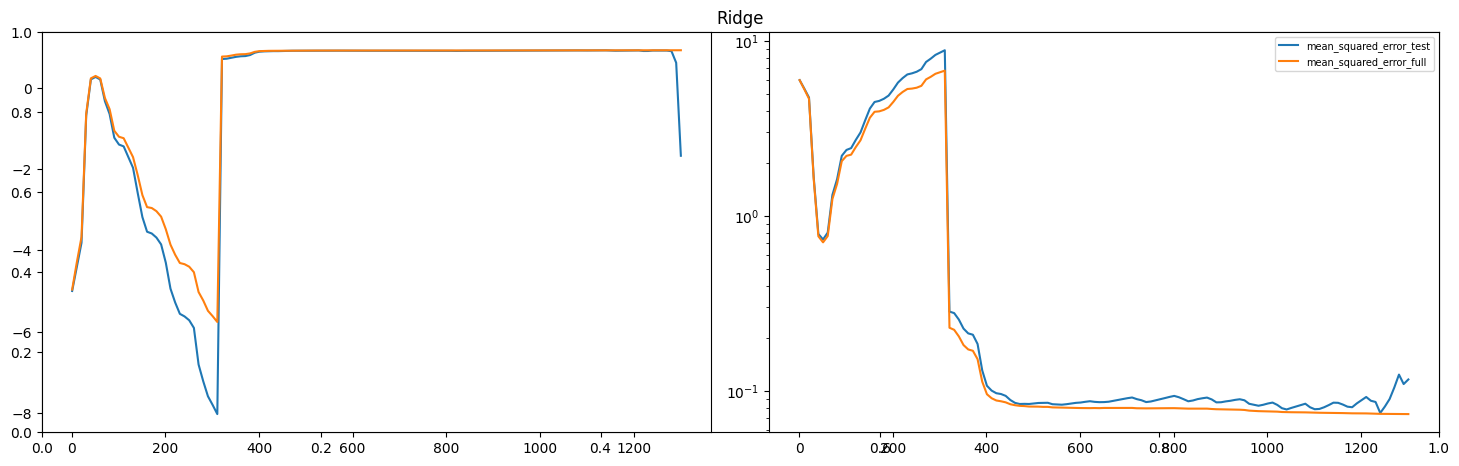

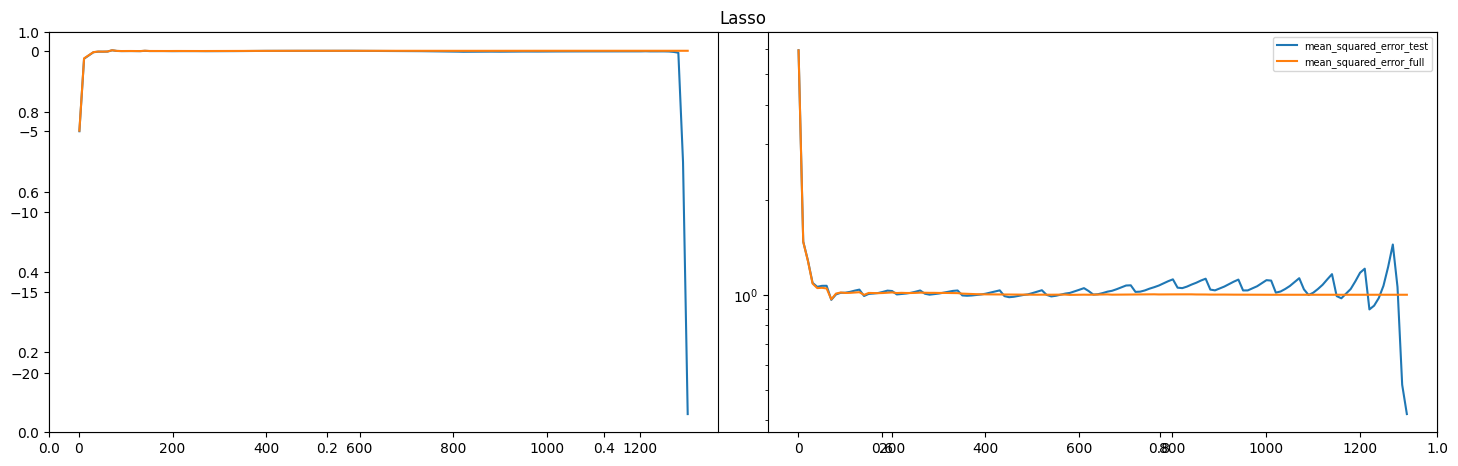

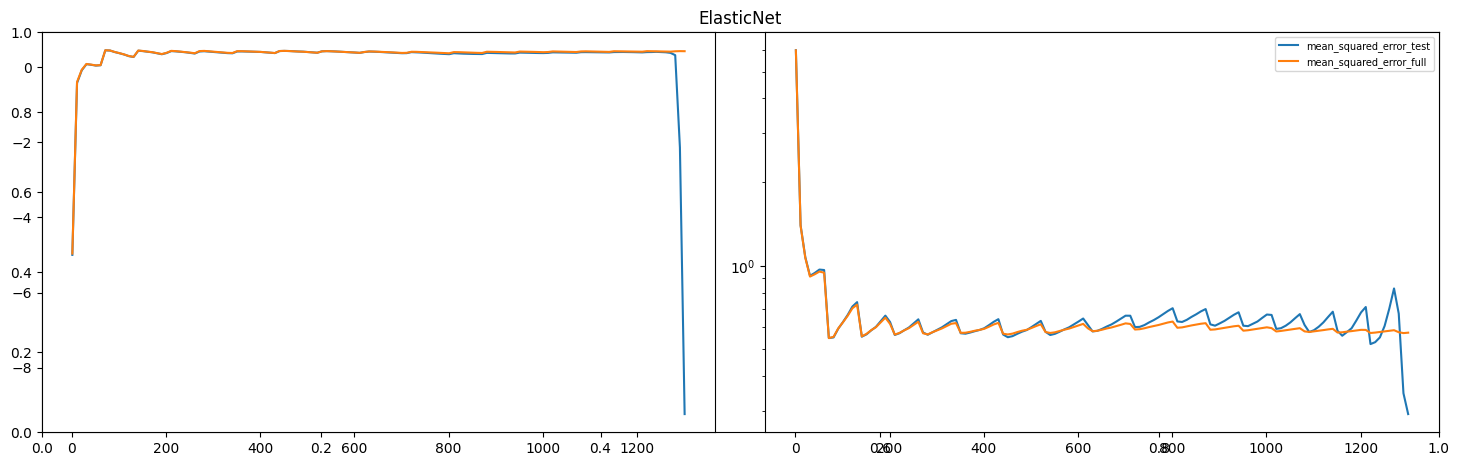

Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning Ridge_cv
Tuning R

ValueError: x and y must have same first dimension, but have shapes (131,) and (130,)

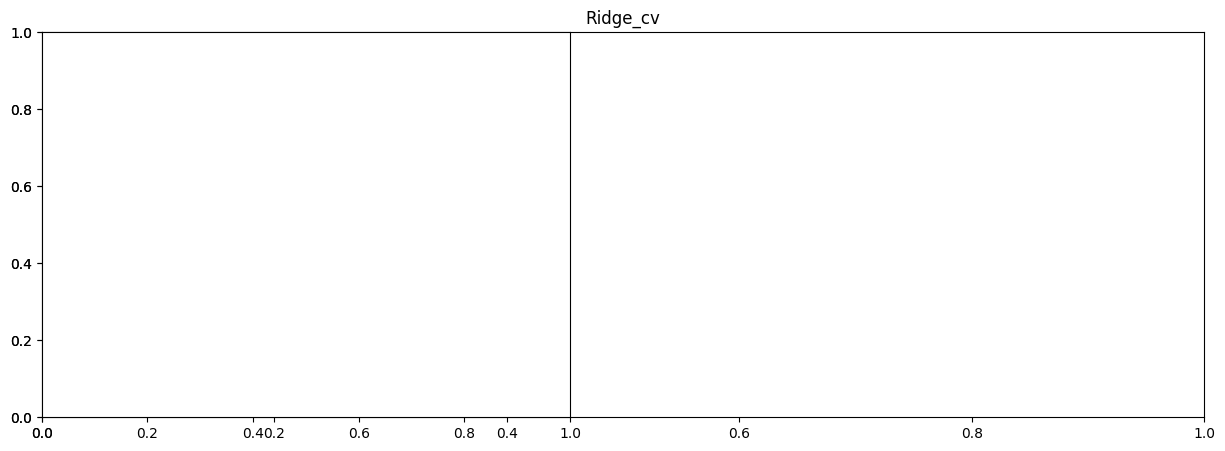

In [ ]:

list_of_models = []
list_of_models.append(sklearn.linear_model.LinearRegression())
list_of_models.append(sklearn.linear_model.Ridge())
list_of_models.append(sklearn.linear_model.Lasso())
list_of_models.append(sklearn.linear_model.ElasticNet())


model_names = ["LinearRegression","Ridge","Lasso","ElasticNet","Ridge_cv"]
alphas = np.logspace(-10, 3, 10)
param_grid_ridge = {'alpha': alphas}
# param_grid_lasso = {'alpha': alphas}
# param_grid_elastic_net = {'alpha': alphas, 'l1_ratio': np.linspace(0, 1, 10)}
ridge_cv = GridSearchCV(sklearn.linear_model.Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
# lasso_cv = GridSearchCV(sklearn.linear_model.Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
# elastic_net_cv = GridSearchCV(sklearn.linear_model.ElasticNet(), param_grid_elastic_net, cv=5, scoring='neg_mean_squared_error')
models_to_tune = [ridge_cv]
list_of_models.extend(models_to_tune)

for model in list_of_models:
    accuracy_score_test = []
    accuracy_score_full = []
    mean_squared_error_test = []
    mean_squared_error_full = []
    t_train_values = []
    for T_train in range(1,len(t)-10,10):
        t_train_values.append(T_train)
        Z_train = Z_scaled[:T_train,:]
        Z_test = Z_scaled[T_train:,:]
        Y_train = Y_scaled[:T_train,:]
        Y_test = Y_scaled[T_train:,:]
        try:
            if model in models_to_tune:
                print(f"Tuning {model_names[list_of_models.index(model)]}")
                model.fit(Z_train, Y_train)
                Y_pred = model.predict(Z_test)
                accuracy_score_test.append(model.score(Z_test, Y_test))
                mean_squared_error_test.append(mean_squared_error(Y_test, Y_pred))
                Y_full_pred = model.predict(Z_scaled)
                accuracy_score_full.append(model.score(Z_scaled, Y_scaled))
                mean_squared_error_full.append(mean_squared_error(Y_scaled, Y_full_pred))
                
            else:
                model.fit(Z_train, Y_train)
                Y_pred = model.predict(Z_test)
                accuracy_score_test.append(model.score(Z_test, Y_test))
                mean_squared_error_test.append(mean_squared_error(Y_test, Y_pred))
                # print(f"Accuracy between Y_pred and Y_test: {reg.score(Z_test, Y_test)}")
                Y_full_pred = model.predict(Z_scaled)
                accuracy_score_full.append(model.score(Z_scaled, Y_scaled))
                mean_squared_error_full.append(mean_squared_error(Y_scaled, Y_full_pred))
        except:
            # print(f"Error fitting {model_names[list_of_models.index(model)]}")
            continue
        # print(f"Accuracy between Y_full_pred and Y_full: {reg.score(Z_scaled, Y_scaled)}")
    # Plotting the accuracy score
    # print(f"Accuracy score test: {accuracy_score_test}\nAccuracy score full: {accuracy_score_full}")
    plt.figure(figsize=(15,5))
    plt.title(model_names[list_of_models.index(model)])
    plt.subplot(1, 2, 1)
    plt.plot(t_train_values,accuracy_score_test,label='accuracy_score_test')
    plt.plot(t_train_values,accuracy_score_full,label='accuracy_score_full')
    plt.subplot(1, 2, 2)
    plt.plot(t_train_values,mean_squared_error_test,label='mean_squared_error_test')
    plt.plot(t_train_values,mean_squared_error_full,label='mean_squared_error_full')
    plt.legend(loc = 1, fontsize = 7)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()




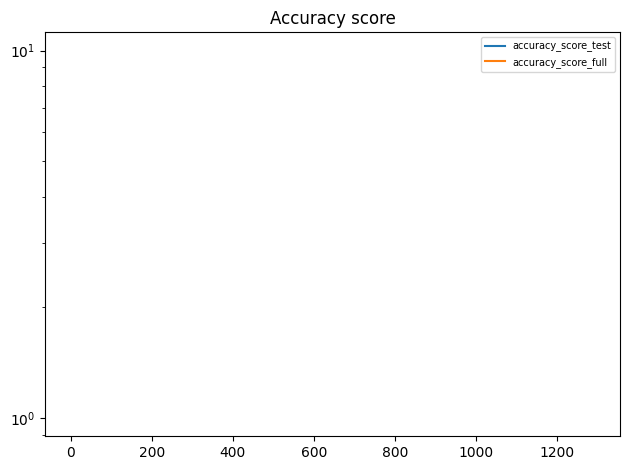

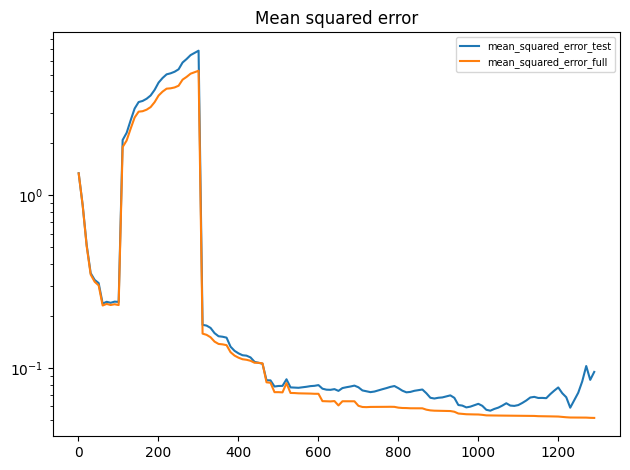

In [13]:
plt.title("Accuracy score")
# plt.subplot(1, 2, 1)
plt.plot(t_train_values[:-1],accuracy_score_test,label='accuracy_score_test')
plt.plot(t_train_values[:-1],accuracy_score_full,label='accuracy_score_full')
plt.legend(loc = 1, fontsize = 7)
plt.yscale('log')
plt.tight_layout()
plt.show()
plt.title("Mean squared error")
# plt.subplot(1, 2, 2)
plt.plot(t_train_values[:-1],mean_squared_error_test,label='mean_squared_error_test')
plt.plot(t_train_values[:-1],mean_squared_error_full,label='mean_squared_error_full')
plt.legend(loc = 1, fontsize = 7)
plt.yscale('log')
plt.tight_layout()
plt.show()

- Pydmd and PySindy approach

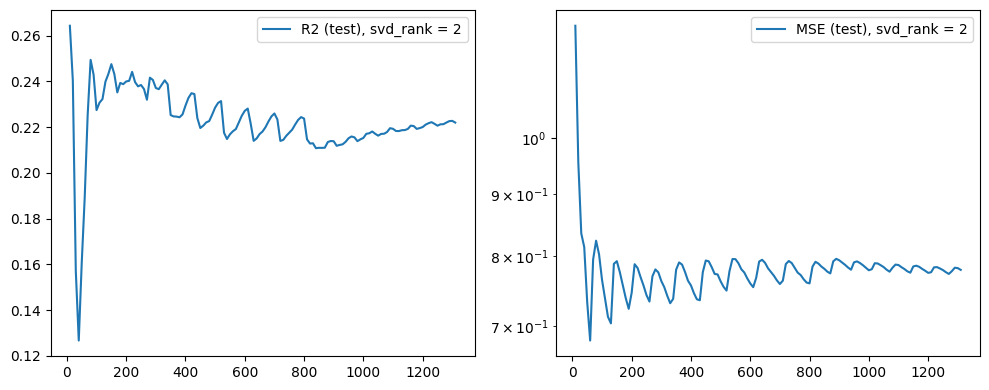

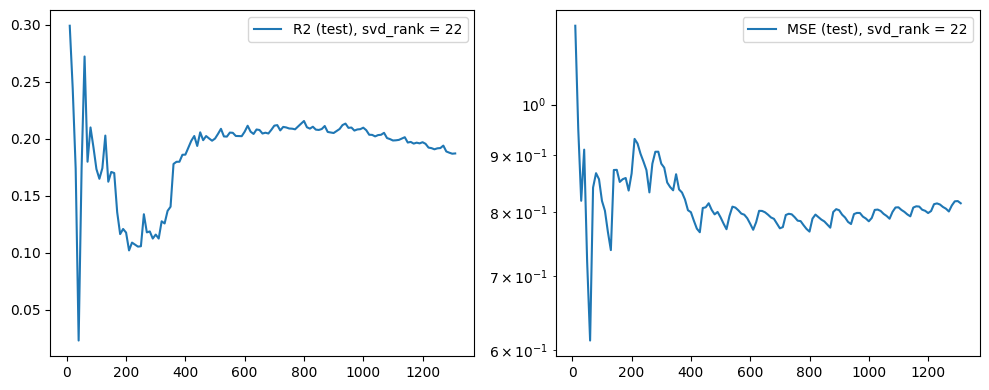

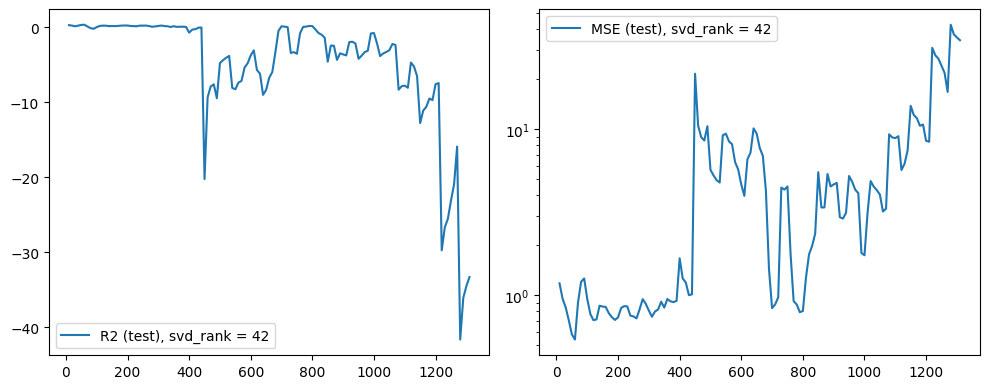

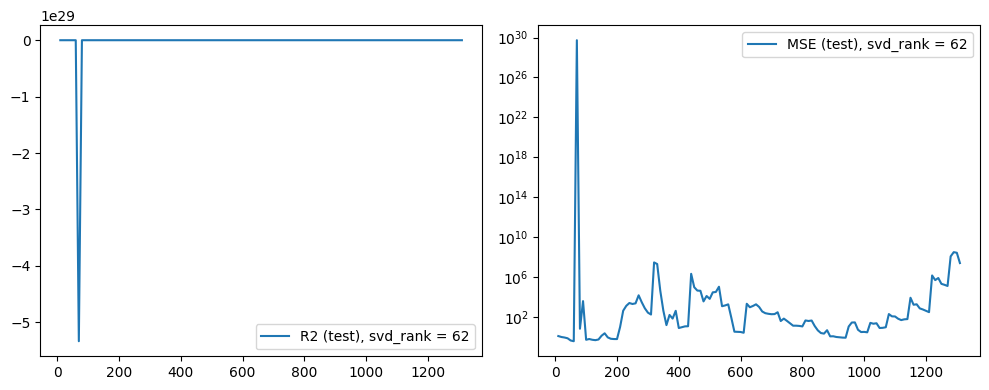

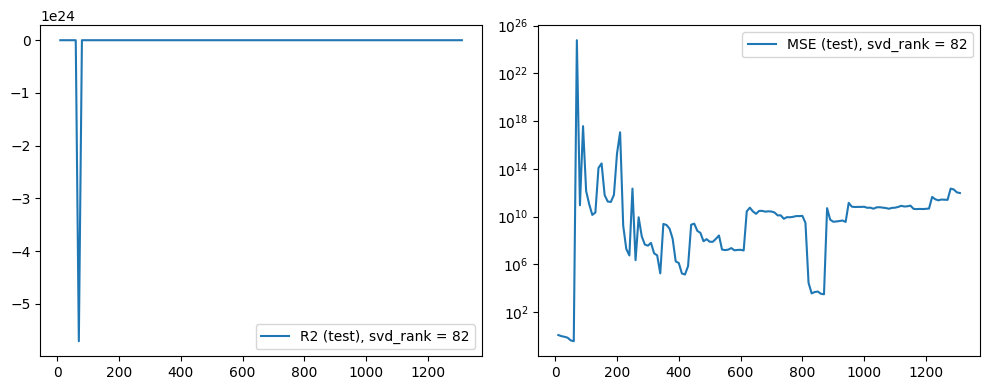

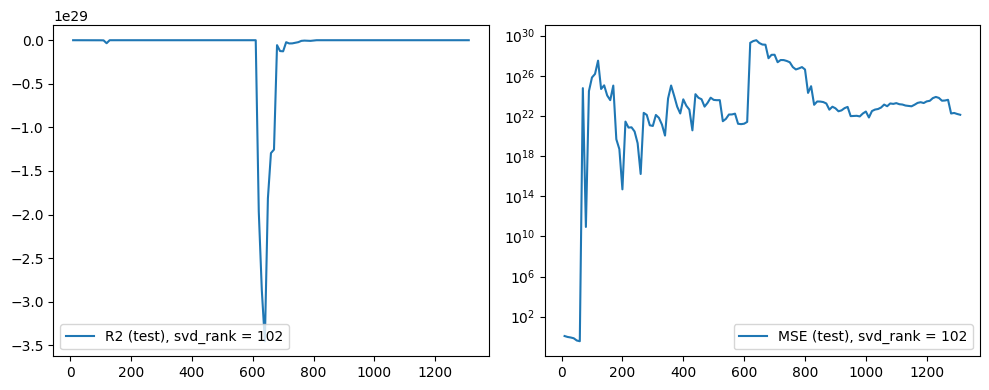

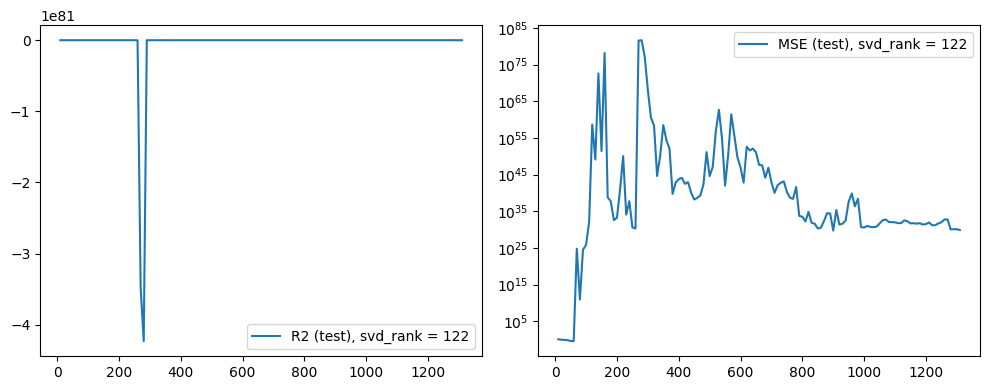

C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:584: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:1292: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\ticker.py:2468: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


OverflowError: cannot convert float infinity to integer

Error in callback <function _draw_all_if_interactive at 0x000002AB0784E8C0> (for post_execute), with arguments args (),kwargs {}:


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 1000x400 with 2 Axes>

In [ ]:


accuracy_score_test = []
mean_squared_error_test = []
t_train_values = []
for svd_rank in range(2,min(Z_scaled.shape[0],Z_scaled.shape[1]),20):
    
    accuracy_score_test = []
    mean_squared_error_test = []
    t_train_values = []
    for T_train in range(10, Z_scaled.shape[0], 10):
        t_train_values.append(T_train)
        # DMD expects data as (features, snapshots)
        X_train = Z_scaled[:T_train, :]
        # print(f"X_train shape: {X_train.shape}")
        dmd = DMD(svd_rank=svd_rank)  # adjust svd_rank as needed
        dmd.fit(X_train)
        # Predict next steps
        X_test = Z_scaled[T_train:, :]
        X_pred = dmd.reconstructed_data.real # same shape as X_train
        # Extrapolation to the future X_test

        # print(f"X_test shape: {X_test.shape}\nX_pred shape: {X_pred.shape}")
        # Compute metrics
        mse = mean_squared_error(X_train.flatten(), X_pred.flatten())
        r2 = r2_score(X_train.flatten(), X_pred.flatten())
        mean_squared_error_test.append(mse)
        accuracy_score_test.append(r2)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(t_train_values, accuracy_score_test, label=f'R2 (test), svd_rank = {svd_rank}')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(t_train_values, mean_squared_error_test, label=f'MSE (test), svd_rank = {svd_rank}')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.yscale('log')
    plt.show()

C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


X_test shape: (1303, 171)
X_pred shape: (1303, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (1172, 171)
X_pred shape: (1172, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (1041, 171)
X_pred shape: (1041, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (910, 171)
X_pred shape: (910, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (779, 171)
X_pred shape: (779, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (648, 171)
X_pred shape: (648, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (517, 171)
X_pred shape: (517, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (386, 171)
X_pred shape: (386, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (255, 171)
X_pred shape: (255, 171)


C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
C:\Users\arofe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Spars

X_test shape: (124, 171)
X_pred shape: (124, 171)


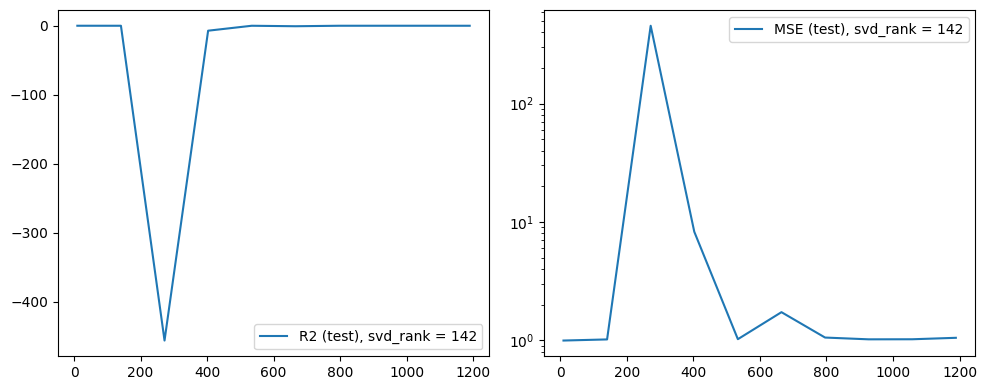

In [ ]:

accuracy_score_test = []
mean_squared_error_test = []
t_train_values = []
# for svd_rank in range(2,min(Z_scaled.shape[0],Z_scaled.shape[1]),10):
    
accuracy_score_test = []
mean_squared_error_test = []
t_train_values = []
for T_train in range(10, Z_scaled.shape[0], 1313//10):
    t_train_values.append(T_train)
    # DMD expects data as (features, snapshots)
    X_train = Z_scaled[:T_train, :]
    # print(f"X_train shape: {X_train.shape}")
    sindy = ps.SINDy()  # adjust svd_rank as needed
    sindy.fit(X_train)
    # Predict next steps
    X_test = Z_scaled[T_train:, :]
    X_pred = sindy.predict(X_test) # same shape as X_train
    # Extrapolation to the future X_test

    print(f"X_test shape: {X_test.shape}\nX_pred shape: {X_pred.shape}")
    # Compute metrics
    mse = mean_squared_error(X_test.flatten(), X_pred.flatten())
    r2 = r2_score(X_test.flatten(), X_pred.flatten())
    mean_squared_error_test.append(mse)
    accuracy_score_test.append(r2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t_train_values, accuracy_score_test, label=f'R2 (test), svd_rank = {svd_rank}')
plt.legend()
plt.subplot(1,2,2)
plt.plot(t_train_values, mean_squared_error_test, label=f'MSE (test), svd_rank = {svd_rank}')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

### Optimization methods

- We assume the relation:
$$y_k = Ay_{k-1} + B x_{k-1}$$
where $y_k\in \mathbb{R}^{2n}, x_k \in \mathbb{R}^{3n}$
- We want to find the best fit matrix $A$ and $B$ such that:
$$A,B = \argmin_{A,B}\sum_{k=1}^K\|y_k-Ay_{k-1}-Bx_{k-1}\|^2$$
where $x_k$ represents the pressure, water holdup and gaz holdup, $y_k$ represent the velocity holdup.


X_train shape: (171, 656) | Y_train shape: (114, 656) | X_val shape: (171, 328) | Y_val shape: (114, 328) | X_test shape: (171, 329) | Y_test shape: (114, 329)
(1313, 171)
(1313, 114)
i: 0 | Train Loss: 0.244134 | Val Loss: 0.242402 | A.norm: 1.596347 | B.norm: 1.975432
i: 1000 | Train Loss: 0.005808 | Val Loss: 0.003042 | A.norm: 1.857462 | B.norm: 1.964495
i: 2000 | Train Loss: 0.005798 | Val Loss: 0.003036 | A.norm: 1.866264 | B.norm: 1.987400
i: 3000 | Train Loss: 0.005787 | Val Loss: 0.003036 | A.norm: 1.867791 | B.norm: 1.988633
Early stopping at iteration 3342


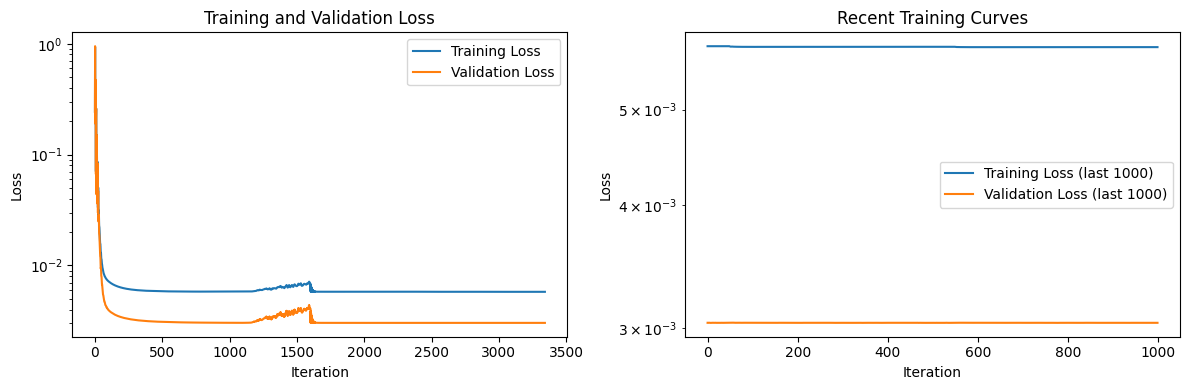

In [ ]:
percentage = 0.5
X_train = P_wh_ph[:,:int(len(t)*percentage)]
Y_train = v_w_g[:,:int(len(t)*percentage)]
X_val = P_wh_ph[:,int(len(t)*percentage):int(len(t)*(percentage+percentage/2))]
Y_val = v_w_g[:,int(len(t)*percentage):int(len(t)*(percentage+percentage/2))]
X_test = P_wh_ph[:,int(len(t)*(percentage+percentage/2)):]
Y_test = v_w_g[:,int(len(t)*(percentage+percentage/2)):]
print(f"X_train shape: {X_train.shape} | Y_train shape: {Y_train.shape} | X_val shape: {X_val.shape} | Y_val shape: {Y_val.shape} | X_test shape: {X_test.shape} | Y_test shape: {Y_test.shape}")

print(Z_scaled.shape)
print(Y_scaled.shape)

n_features = Z_scaled.shape[1]//3
assert n_features == Y_scaled.shape[1]//2

# Initialize parameters with proper scaling
A = torch.randn(2*n_features,2*n_features,dtype=torch.float64) * 0.01
B = torch.randn(2*n_features,3*n_features,dtype=torch.float64) * 0.01

# Enhanced optimizer with better regularization
optimizer = torch.optim.AdamW([A,B], lr=0.01, weight_decay=1e-4)  # Increased weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500)
A.requires_grad_(True)
B.requires_grad_(True)
# Custom loss function with regularization
def custom_loss(pred, target, A, B, lambda_l1=1e-5, lambda_l2=1e-4):
    mse_loss = torch.nn.MSELoss()(pred, target)
    l1_reg = lambda_l1 * (torch.norm(A, p=1) + torch.norm(B, p=1))
    l2_reg = lambda_l2 * (torch.norm(A, p=2)**2 + torch.norm(B, p=2)**2)
    return mse_loss + l1_reg + l2_reg

X_train_torch = torch.tensor(X_train, dtype=torch.float64)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float64)
X_val_torch = torch.tensor(X_val, dtype=torch.float64)
Y_val_torch = torch.tensor(Y_val, dtype=torch.float64)
X_test_torch = torch.tensor(X_test, dtype=torch.float64)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float64)

# Early stopping parameters
patience = 1000
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for i in range(10000):
    optimizer.zero_grad()
    
    # Training
    a = A @ Y_train_torch[:,:-1]
    b = B @ X_train_torch[:,:-1]
    train_pred = a + b
    train_loss = custom_loss(train_pred, Y_train_torch[:,1:], A, B)
    
    # Validation
    with torch.no_grad():
        a_val = A @ Y_val_torch[:,:-1]
        b_val = B @ X_val_torch[:,:-1]
        val_pred = a_val + b_val
        val_loss = torch.nn.MSELoss()(val_pred, Y_val_torch[:,1:])
    
    train_loss.backward()
    optimizer.step()
    scheduler.step(val_loss)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_A = A.clone()
        best_B = B.clone()
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at iteration {i}")
        A.data = best_A.data
        B.data = best_B.data
        break
    
    if i % 1000 == 0:
        print(f"i: {i} | Train Loss: {train_loss.item():.6f} | Val Loss: {val_loss.item():.6f} | A.norm: {A.norm():.6f} | B.norm: {B.norm():.6f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(train_losses[-1000:], label='Training Loss (last 1000)')
plt.plot(val_losses[-1000:], label='Validation Loss (last 1000)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Recent Training Curves')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

a.shape: torch.Size([114, 328]) | b.shape: torch.Size([114, 328])
a.requires_grad: False | b.requires_grad: False
Y_test[:,1:].shape: (114, 328) | a+b.shape: torch.Size([114, 328])
dtype: torch.float64 | Y_test[:,1:].dtype: float64
mse: 0.0034475529896566847


In [89]:
a = A @ Y_test[:,:-1]
b = B @ X_test[:,:-1]
test_pred = a + b
mse = torch.nn.MSELoss()(test_pred, Y_test[:,1:])
print(f"mse: {mse}")
print(f"a.shape: {a.shape} | b.shape: {b.shape}")
print(f"a.requires_grad: {a.requires_grad} | b.requires_grad: {b.requires_grad}")
print(f"Y_test[:,1:].shape: {Y_test[:,1:].shape} | a+b.shape: {a+b.shape}")
print(f"dtype: {a.dtype} | Y_test[:,1:].dtype: {Y_test[:,1:].dtype}")


In [90]:
a = A @ Y_test[:,:-1]
b = B @ X_test[:,:-1]
test_pred = a + b
mse = torch.nn.MSELoss()(test_pred, Y_test[:,1:])
print(f"mse: {mse}")
print(f"a.shape: {a.shape} | b.shape: {b.shape}")
print(f"a.requires_grad: {a.requires_grad} | b.requires_grad: {b.requires_grad}")
print(f"Y_test[:,1:].shape: {Y_test[:,1:].shape} | a+b.shape: {a+b.shape}")
print(f"dtype: {a.dtype} | Y_test[:,1:].dtype: {Y_test[:,1:].dtype}")


# PySINDy Model

In [54]:

from pydmd import DMD

# Transpose data to (time, space) format
Z = Z.T  # Now shape (1313, 171)
Y = Y.T  # Now shape (1313, 113)

# Fit DMD on Z (observations)
dmd = DMD(svd_rank=50)  # Reduce to 50 modes
dmd.fit(Z)

# Predict Y using DMD modes
Y_pred_dmd = dmd.reconstructed_data.T  # Shape (1313, 113)



In [56]:

from pysindy import SINDy
from sklearn.preprocessing import StandardScaler

# Reshape data for SINDy: Combine Z and Y into a single state vector
# Stack Z (171) and Y (113) features at each time step
X_sindy = np.vstack([Z.T, Y.T]).T  # Shape (1313, 171 + 113)

# Normalize data
scaler = StandardScaler()
X_sindy_scaled = scaler.fit_transform(X_sindy)

# Fit SINDy model (sparse nonlinear dynamics)
model = SINDy(
    optimizer="STLSQ",  # Sparse thresholded least squares
    feature_library="polynomial",  # Nonlinear terms
    differentiation_method="finite_difference")

model.fit(X_sindy_scaled, t=1.0)  # t is time step
model.print()  # Show learned equations

# Predict future states
X_pred = model.simulate(X_sindy_scaled[0], n_steps=1313)
X_pred = scaler.inverse_transform(X_pred)  # Rescale back



AttributeError: 'str' object has no attribute 'correct_shape'